<a href="https://colab.research.google.com/github/karimdjemai/stockPricePred/blob/master/jupyter.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Stock Prices Prediction Using Keras Long Term Short Memory

In [0]:
# Part 1 - Data Preprocessing

# Importing the libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [0]:
# Importing the training set
dataset_train = pd.read_csv('train.csv')
training_set = dataset_train.iloc[:, 1:2].values

In [28]:
timesteps=168
pred_steps=24
train_length=training_set.flatten().size
print(train_length)

25440


In [0]:
# Feature Scaling
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler(feature_range = (0, 1))
training_set_scaled = sc.fit_transform(training_set)

In [0]:
# Creating a data structure with 60 timesteps and 1 output
X_train = []
y_train = []
for i in range(timesteps, train_length-pred_steps):
    X_train.append(training_set_scaled[i-timesteps:i, 0])
    y_train.append(training_set_scaled[i:i+pred_steps, 0])
X_train, y_train = np.array(X_train), np.array(y_train)

In [0]:
# Reshaping
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

In [0]:
# Part 2 - Building the RNN

# Importing the Keras libraries and packages
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout

In [0]:
# Initialising the RNN
regressor = Sequential()

# Adding the first LSTM layer and some Dropout regularisation
regressor.add(LSTM(units = 200, return_sequences = True, input_shape = (None, 1)))
regressor.add(Dropout(0.2))

In [0]:
# Adding a fourth LSTM layer and some Dropout regularisation
regressor.add(LSTM(units = 50))

In [0]:
# Adding the output layer
regressor.add(Dense(units = 400))

# Adding the output layer
regressor.add(Dense(units = pred_steps))

# Compiling the RNN
regressor.compile(optimizer = 'adam', loss = 'mean_squared_error')

# Fitting the RNN to the Training set
regressor.fit(X_train, y_train, epochs = 10, batch_size = 32)

In [36]:
# Part 3 - Making the predictions and visualising the results
regressor.load_weights('model.h5')


# Getting the real stock price of 2017
dataset_test = pd.read_csv('test.csv')
real_stock_price = dataset_test.iloc[:, 1:2].values

In [0]:
# Getting the predicted stock price of 2017
dataset_total = pd.concat((dataset_train['Open'], dataset_test['Open']), axis = 0)
inputs = dataset_total[len(dataset_total) - len(dataset_test) - timesteps:].values
inputs = inputs.reshape(-1,1)

inputs = sc.transform(inputs)

X_test = []

#for i in range(60, 61):
#    X_test.append(inputs[i-60:i, 0])

X_test.append(inputs[0:timesteps, 0])


X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

In [90]:
predicted_stock_price = []
for i in range(0,2):
  result = regressor.predict(X_test)[0]
  predicted_stock_price = np.append(predicted_stock_price, result)
  X_test = np.roll(X_test, -pred_steps)
  np.append(X_test[0][0], result)

#predicted_stock_price = regressor.predict(X_test)[0]

predicted_stock_price = sc.inverse_transform(predicted_stock_price.reshape(-1, 1))

print(predicted_stock_price[-24:])

[[121.86766229]
 [121.9609144 ]
 [121.61662735]
 [121.85202408]
 [121.76306376]
 [121.67350059]
 [121.62597796]
 [121.669727  ]
 [121.86944776]
 [121.67411114]
 [121.65003557]
 [121.62114745]
 [121.53479351]
 [121.54991353]
 [121.2937659 ]
 [121.53036319]
 [121.13599589]
 [121.37900906]
 [121.27021365]
 [121.44341922]
 [121.33654524]
 [121.38529923]
 [121.30321398]
 [121.41698355]]


In [0]:
predicted_stock_price = predicted_stock_price + np.ones_like(predicted_stock_price)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: MatplotlibDeprecationWarning: 
The frameon kwarg was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use facecolor instead.
  if sys.path[0] == '':


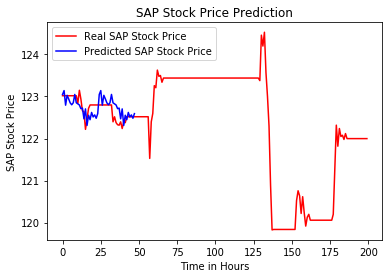

In [88]:
# Visualising the results
plt.plot(real_stock_price[:-24], color = 'red', label = 'Real SAP Stock Price')
plt.plot(predicted_stock_price, color = 'blue', label = 'Predicted SAP Stock Price')
#plt.plot(training_set[-24:], color = 'black', label = 'Historical SAP Stock Price')
#plt.plot(training_set[-168:], color='green', label = 'Historical SAP Stock Price')
plt.title('SAP Stock Price Prediction')
plt.xlabel('Time in Hours')
plt.ylabel('SAP Stock Price')
plt.legend()
plt.savefig('predicted_train.svg', dpi=200, facecolor='w', edgecolor='w',
        orientation='landscape', papertype=None, format='svg',
        transparent=True, bbox_inches=None, pad_inches=0.1,
        frameon=None, metadata=None)
plt.show()

In [0]:

regressor.save('model.h5')